In [104]:
import json
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection   import cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.metrics           import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Importing dataset

In [18]:
#importing file from the url
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz

--2020-06-24 13:47:09--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47285200 (45M) [application/x-gzip]
Saving to: ‘reviews_Clothing_Shoes_and_Jewelry_5.json.gz’

reviews_Clothing_Sh 100%[===================>]  45.09M  1.04MB/s    in 62s     

2020-06-24 13:48:12 (742 KB/s) - ‘reviews_Clothing_Shoes_and_Jewelry_5.json.gz’ saved [47285200/47285200]



In [36]:
file = 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
df = pd.read_json(file, lines=True, compression='gzip')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


# Data exploration (before cleaning)

In [40]:
#selecting only 2 columns
data = pd.concat([df['reviewText'], df['overall']], axis=1)
data.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,5
1,I bought this for my 4 yr old daughter for dan...,5
2,What can I say... my daughters have it in oran...,5
3,"We bought several tutus at once, and they are ...",5
4,Thank you Halo Heaven great product for Little...,5


In [16]:
data.isna().sum()

reviewText    0
overall       0
dtype: int64

In [39]:
data.isnull().values.any()

False

5    163240
4     58357
3     30425
2     15463
1     11192
Name: overall, dtype: int64


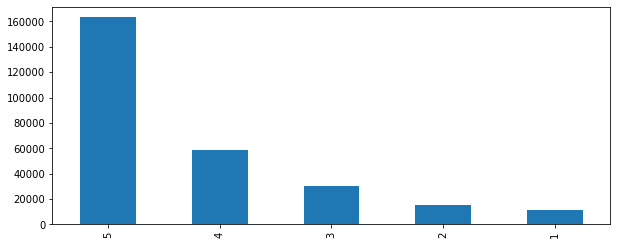

In [99]:
distr = data['overall'].value_counts()
print(distr)
plt.figure(figsize=(10,4))
distr.plot(kind='bar')

In [42]:
data['word_number'] = data['reviewText'].apply(lambda x: len(x.split(' ')))
data.head()

,reviewText,overall,word_number
0,This is a great tutu and at a really great pri...,5,35
1,I bought this for my 4 yr old daughter for dan...,5,61
2,What can I say... my daughters have it in oran...,5,62
3,"We bought several tutus at once, and they are ...",5,76
4,Thank you Halo Heaven great product for Little...,5,87


In [73]:
data['word_number'].describe()

count    278677.000000
mean         61.211776
std          62.419374
min           1.000000
25%          27.000000
50%          42.000000
75%          72.000000
max        3926.000000
Name: word_number, dtype: float64

In [97]:
gr = data.groupby('overall')['word_number'].agg([np.min, np.max, np.mean, np.median])
gr

,amin,amax,mean,median
overall,,,,
1,1,860,65.290029,46
2,1,1334,67.133415,48
3,1,3926,65.809006,47
4,1,2211,66.394126,46
5,1,2158,57.661743,39


In [57]:
print('Average word length of phrases is {0:.0f}.'.format(np.mean(data['reviewText'].apply(lambda x: len(x.split())))))

Average word length of phrases is 60.


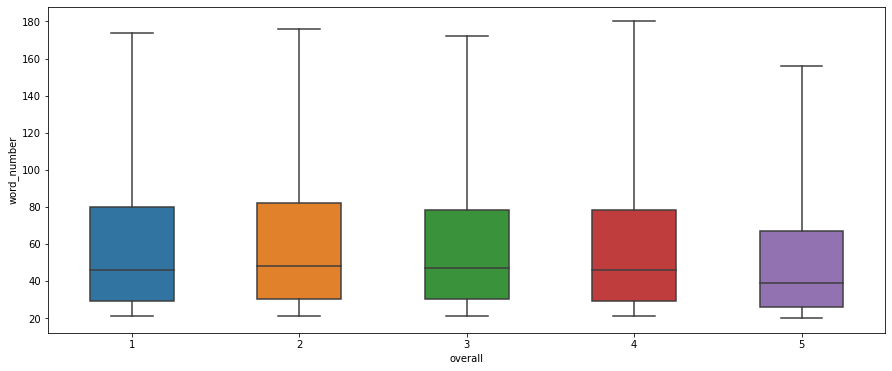

In [80]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data, x='overall', y='word_number', width=.5, showfliers=False, whis=[5,95])

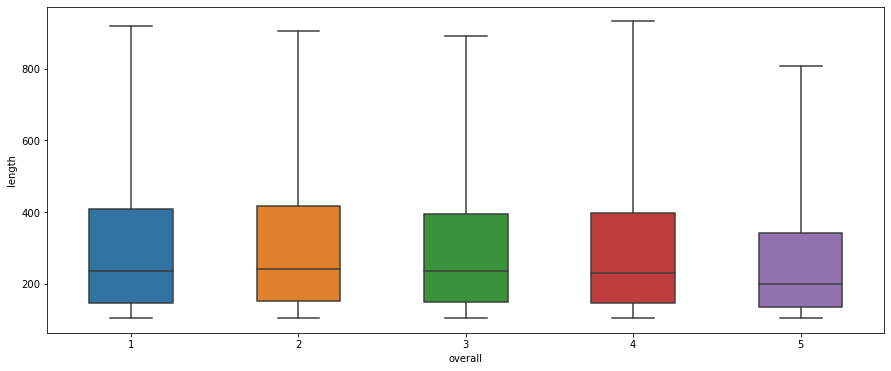

In [81]:
data['length'] = data['reviewText'].str.len()
plt.figure(figsize=(15,6))
sns.boxplot(data=data, x='overall', y='length', width=.5, showfliers=False, whis=[5,95])

In [85]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
import string
import re

# Data cleaning

In [86]:
def clean_doc(doc):
    tokens = doc.split()
    tokens = [word.lower() for word in tokens]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return " ".join(tokens)

In [87]:
clean_data = []
for i in range(0, len(data)):
    clean_t=clean_doc(data['reviewText'][i])
    clean_data.append(clean_t)

In [93]:
data['cleaned'] = data['reviewText'].apply(clean_doc)

In [94]:
data.head()

,reviewText,overall,word_number,length,cleaned
0,This is a great tutu and at a really great pri...,5,35,172,great tutu really great price doesnt look chea...
1,I bought this for my 4 yr old daughter for dan...,5,61,306,bought yr old daughter dance class wore today ...
2,What can I say... my daughters have it in oran...,5,62,312,say daughters orange black white pink thinking...
3,"We bought several tutus at once, and they are ...",5,76,405,bought several tutus got high reviews sturdy s...
4,Thank you Halo Heaven great product for Little...,5,87,453,thank halo heaven great product little girls g...


# Data exploration after cleaning

In [59]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [66]:
n = len(data["overall"].unique())

Word Cloud for Score 1:


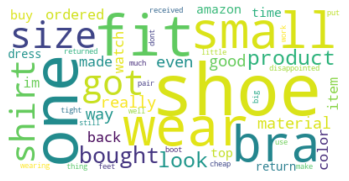

Word Cloud for Score 2:


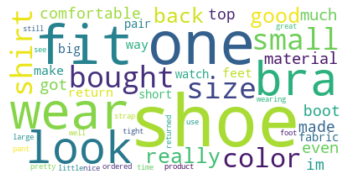

Word Cloud for Score 3:


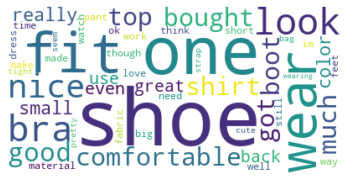

Word Cloud for Score 4:


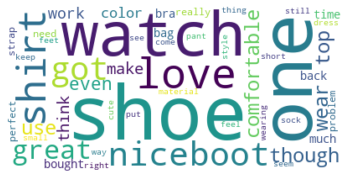

Word Cloud for Score 5:


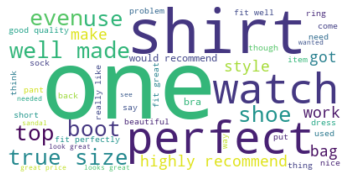

In [96]:
for i in range(1, n+1):
    txt = data[data["overall"]==i]["cleaned"] 
    collapsed_txt = txt.str.cat(sep=' ')
    wordcloud = WordCloud(background_color="white",max_words=50).generate(collapsed_txt)
    print("Word Cloud for Score {}:".format(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Dataset splitting

In [105]:
X_train, X_test, y_train, y_test = train_test_split(data["cleaned"], data["overall"],random_state = 42,test_size = 0.33)

In [122]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Baseline model - Logistic regression

In [127]:
vectorizer = TfidfVectorizer()

In [132]:
pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter = 7000)),
     ])

In [135]:
model = pipe.fit(X_train, y_train)

In [136]:
print("Accuracy of Logistic regression Classifier is {}".format(model.score(X_test,y_test)))

Accuracy of Logistic regression Classifier is 0.665564786220695
